CityscapesDataset initialized with 1 samples
Data augmentation techniques enabled: True
Loading sample: dusseldorf/dusseldorf_000000_000019
Image path: /content/drive/MyDrive/MAGISTRALE/ANNO 1/Computer Vision/Project/RoadObstacleDetection/Datasets/leftImg8bit_trainvaltest/leftImg8bit_trainvaltest/leftImg8bit/train/dusseldorf/dusseldorf_000000_000019_leftImg8bit.png
Labels path: /content/drive/MyDrive/MAGISTRALE/ANNO 1/Computer Vision/Project/RoadObstacleDetection/Datasets/leftImg8bit_trainvaltest/gtFine_trainvaltest/gtFine/train/dusseldorf/dusseldorf_000000_000019_gtFine_labelIds.png
Loaded image shape: (1024, 2048, 3)
Loaded labels shape: (1024, 2048)
Label remapped, unique values: [0 1 2 3 4 5 6]
Object mask created, unique values: [0 1]
Resized to fixed size
Final IMAGE tensor shape: torch.Size([3, 512, 1024])
Final LABELS tensor shape: torch.Size([512, 1024])
Final OBJECTNESS tensor shape: torch.Size([512, 1024])


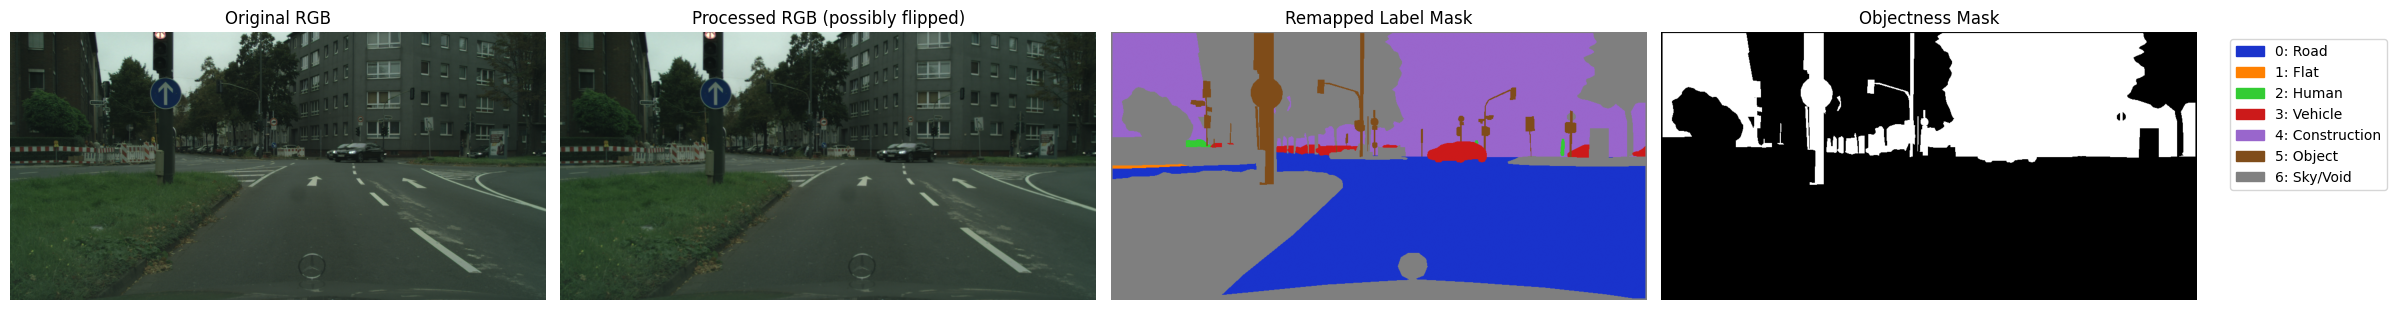

In [ ]:
#===============================================================
# DEBUG TOGGLE SWITCH
def d(*args, **kwargs):
    if d.ON:
        print(*args, **kwargs)
d.ON = False  # ← set True to enable debug output
#=============================================================


#=========================================================
# IMPORTS
import os
from PIL import Image
import numpy as np

import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
d("Libraries imported successfully")
#===============================================================


#============================================================
# REMAPPING DEFINITION

# 0 = road
# 1 = flat (non drivable flat ground)
# 2 = human
# 3 = vehicle
# 4 = construction
# 5 = object (WATCH OUT, NOT THE OBJECT IN GENERAL BUT IT'S A SPECIFIC CITYSCAPES LABEL)
# 6 = sky/void (all the rest)

REMAPPING_34_TO_7 = {

    0: 6, 1: 6, 2: 6, 3: 6, 4: 6, 5: 6, 6: 6, # 0–6: mostly void/background

    7: 0, # road

    8: 1, 9: 1, # flat (sidewalk, terrain)

    10: 6, # sky

    11: 4, 12: 4, 13: 4, # construction

    14: 6, 15: 6, 16: 6, # traffic objects

    17: 5, 18: 5, 19: 5, 20: 5, # object (pole, traffic light, sign)

    21: 6, 22: 6, 23: 6, # ignore

    24: 2, 25: 2, # humans

    26: 3, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 3, 33: 3, # vehicles

    255: 6 # unknown
}
d("Defined remapping with", len(REMAPPING_34_TO_7), "label entries")

#checking unmapped classes before going on
ALL_LABEL_IDS = list(range(0, 34)) + [255]
unmapped = [c for c in ALL_LABEL_IDS if c not in REMAPPING_34_TO_7]
d("Unmapped classes (expected 2 be empty):", unmapped)
#===================================================================


#===================================================================
# REMAPPING APPLICATION
def remap_labels(label_array):
    remapped = np.full_like(label_array, fill_value=6)  # default to "void"
    for original_id, target_id in REMAPPING_34_TO_7.items():
        remapped[label_array == original_id] = target_id
    return remapped
#=============================================================


#=======================================================================
# OBJECTNESS MAP ON THE WHOLE IMAGE
def get_objectness_mask(label_array): #related to the entire image, don't kwork pixel by pixel

    object_classes = {2, 3, 4, 5} # classes which will be relevant for object detection: human=2, vehicle=3, construction=4, object=5
    object_mask = np.isin(label_array, list(object_classes)).astype(np.uint8) # creates a 2D boolean array with same shape as label_array; each pixel is t/f; .astype converts the boolean array into integers t1/f0
    return object_mask  # gonna be a binary mask for each pixel
#=======================================================================


#====================================================================
# CITYSCAPES DATASET DEFINITION
class CityscapesDataset(Dataset): # Declaring a custom dataset class that extends Pytorch "Dataset" class
  def __init__(self, images_dir, masks_dir, file_list, augment=False): #Constructor with params
    self.images_dir = images_dir
    self.masks_dir = masks_dir
    self.file_list = file_list
    self.augment = augment

    # Normalization as ImageNet is meant to have
    self.mean = [0.485, 0.456, 0.406]
    self.std = [0.229, 0.224, 0.225]

    d("CityscapesDataset initialized with", len(file_list), "samples")
    d("Data augmentation techniques enabled:", self.augment)

  def __len__(self): #total number of entries in the dataset
    length = len(self.file_list)
    d("Requested dataset length:", length)
    return length

  def __getitem__(self, index): #takes index of the sample 2be retrieved
    rel_path = self.file_list[index] #file list contains all the relative names of the files; rel_path instead is something like "city/city_000000_000019"
    d("Loading sample:", rel_path)

    # now constructing the couples of leftImg8bit sample and labelIds masks (labeled)
    image_path = os.path.join(self.images_dir, rel_path + "_leftImg8bit.png") #path.join concatenates the base directories + rel_path's + suffix
    label_path = os.path.join(self.masks_dir, rel_path + "_gtFine_labelIds.png")
    d("Image path:", image_path)
    d("Labels path:", label_path)

    # now we gonna load em
    image = Image.open(image_path).convert("RGB") #ensuring the 3 channels
    label = Image.open(label_path) #SHOULD NOT BE CONVERTED

    # Conversion to numpy arrays
    image_np = np.array(image)
    label_np = np.array(label)
    d("Loaded image shape:", image_np.shape)
    d("Loaded labels shape:", label_np.shape)


    # APPLYINH THE REMAPPING STRATEGY
    label_remapped = remap_labels(label_np) #function formerly created
    d("Label remapped, unique values:", np.unique(label_remapped))

    object_mask = get_objectness_mask(label_remapped)
    d("Object mask created, unique values:", np.unique(object_mask))

    # DATA AUGMENTATION STRATEGIES PLANNED GET APPLIED
    #in order to use torchvision transforms
    label_pil = Image.fromarray(label_remapped.astype(np.uint8))#PIL wants uint8 arrays
    objmask_pil = Image.fromarray(object_mask.astype(np.uint8))#PIL wants uint8 arrays


    # Always resize to fixed dimensions (512x1024)
    image = T.Resize((512, 1024), interpolation=Image.BILINEAR)(image)
    label_pil = T.Resize((512, 1024), interpolation=Image.NEAREST)(label_pil)
    objmask_pil = T.Resize((512, 1024), interpolation=Image.NEAREST)(objmask_pil)
    d("Resized to fixed size")

    # Apply horizontal flip if augment is enabled
    if self.augment and np.random.rand() < 0.5:
        image = T.functional.hflip(image)
        label_pil = T.functional.hflip(label_pil)
        objmask_pil = T.functional.hflip(objmask_pil)
        d("Horizontal flip applied")

    # CONVERSION 2 TENSOR
    image_tensor = T.ToTensor()(image)
    image_tensor = T.Normalize(self.mean, self.std)(image_tensor)

    #converting masks to long tensors
    label_tensor = torch.from_numpy(np.array(label_pil)).long()
    object_tensor = torch.from_numpy(np.array(objmask_pil)).float()

    d("Final IMAGE tensor shape:", image_tensor.shape)
    d("Final LABELS tensor shape:", label_tensor.shape)
    d("Final OBJECTNESS tensor shape:", object_tensor.shape)


    #RECAPPING FINAL FORMATS PLANNED:
    # image_tensor: [3, 512, 1024] normalized RGB image float32
    # label_tensor: [512, 1024] 7-class labeled pixels
    # object_tensor: [512, 1024] binary mask float32 with 0non-object/1object

    return image_tensor, label_tensor, object_tensor



#========================================================================

#DUMMY EXAMPLE TO TRY THE VISUALIZATION OF THE DATALOADER AND THE REMAPPED CLASSES
if __name__ == "__main__": #no need to comment it, just running when you run it inside this exact notebok
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt
    import torchvision.transforms.functional as TF

    d.ON = True  # enable debug

    # Example relative path from your split list (replace with real one)
    file_list = ["dusseldorf/dusseldorf_000000_000019"]

    # Paths to your Drive folders (edit as needed)
    images_dir = "/content/drive/MyDrive/MAGISTRALE/ANNO 1/Computer Vision/Project/RoadObstacleDetection/Datasets/leftImg8bit_trainvaltest/leftImg8bit_trainvaltest/leftImg8bit/train"

    masks_dir = "/content/drive/MyDrive/MAGISTRALE/ANNO 1/Computer Vision/Project/RoadObstacleDetection/Datasets/leftImg8bit_trainvaltest/gtFine_trainvaltest/gtFine/train"

    # Instantiate dataset
    dataset = CityscapesDataset(images_dir, masks_dir, file_list, augment=True)

    # Load first sample
    image_tensor, label_tensor, object_tensor = dataset[0]
    # Reload the raw image without flip to show it (FOR EXAM PRESENTATION)
    original_img_path = os.path.join(images_dir, file_list[0] + "_leftImg8bit.png")
    original_img = Image.open(original_img_path).convert("RGB")

    # Convert to numpy for plotting
    def denormalize(tensor, mean, std):
      for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
      return tensor


    def show_sample(image_tensor, label_tensor, object_tensor, original_image):
      from matplotlib.colors import ListedColormap

      class_colors = [
          (0.1, 0.2, 0.8),  # Road
          (1.0, 0.5, 0.0),  # Flat
          (0.2, 0.8, 0.2),  # Human
          (0.8, 0.1, 0.1),  # Vehicle
          (0.6, 0.4, 0.8),  # Construction
          (0.5, 0.3, 0.1),  # Object
          (0.5, 0.5, 0.5),  # Sky/Void
      ]
      custom_cmap = ListedColormap(class_colors)

      image_vis = denormalize(image_tensor.clone(), dataset.mean, dataset.std)
      image_np = TF.to_pil_image(image_vis)
      label_np = label_tensor.numpy()
      object_np = object_tensor.numpy()

      fig, axs = plt.subplots(1, 4, figsize=(24, 6))

      axs[0].imshow(original_image)
      axs[0].set_title("Original RGB")

      axs[1].imshow(image_np)
      axs[1].set_title("Processed RGB (possibly flipped)")

      axs[2].imshow(label_np, cmap=custom_cmap, vmin=0, vmax=6)
      axs[2].set_title("Remapped Label Mask")

      axs[3].imshow(object_np, cmap='gray')
      axs[3].set_title("Objectness Mask")

      for ax in axs:
          ax.axis('off')

      class_names = ["Road", "Flat", "Human", "Vehicle", "Construction", "Object", "Sky/Void"]
      patches = [mpatches.Patch(color=class_colors[i], label=f"{i}: {class_names[i]}") for i in range(7)]
      plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
      plt.tight_layout()
      plt.show()


    show_sample(image_tensor, label_tensor, object_tensor, original_img)

